<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Predicción de próxima palabra

### Objetivo
El objetivo es utilizar documentos / corpus para crear embeddings de palabras basado en ese contexto utilizando la layer Embedding de Keras. Se utilizará esos embeddings junto con layers LSTM para predeccir la próxima posible palabra.

In [2]:
import random
import io
import pickle

import numpy as np
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout

### Datos
Utilizaremos como dataset los diálogos de varias películas del universo cinematográfico de Marvel

In [3]:
!pip install gdown

In [4]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('./Marvel Datasets', os.F_OK) is False:
    if os.access('marvel_dataset.zip', os.F_OK) is False:
        url = 'https://drive.google.com/uc?id=1BsAIgNChI16FiV5rBVCTEoavEP5gdnLL&authuser=0&export=download'
        output = 'marvel_dataset.zip'
        gdown.download(url, output, quiet=False)
    !unzip -q marvel_dataset.zip
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


In [5]:
# Peliculas incluidas
import glob
all_files = glob.glob("./Marvel Datasets/*")

print("Nº total de peliculas", len(all_files))
all_files

Nº total de peliculas 23


['./Marvel Datasets/Avengers.txt',
 './Marvel Datasets/Ant-Man.And.The.Wasp.txt',
 './Marvel Datasets/Avengers.Age.of.Ultron.txt',
 './Marvel Datasets/Ant-Man.txt',
 './Marvel Datasets/Captain.Marvel.txt',
 './Marvel Datasets/Captain.America.Civil.War.txt',
 './Marvel Datasets/Spider-Man.Homecoming.txt',
 './Marvel Datasets/Captain.America.The.Winter.Soldier.txt',
 './Marvel Datasets/Doctor.Strange.txt',
 './Marvel Datasets/The.Incredible.Hulk.txt',
 './Marvel Datasets/Spider-Man.Far.From.Home.txt',
 './Marvel Datasets/Iron-Man.3.txt',
 './Marvel Datasets/Iron-Man.2.txt',
 './Marvel Datasets/Guardians.of.the.Galaxy.txt',
 './Marvel Datasets/Thor.The.Dark.World.txt',
 './Marvel Datasets/Guardians.of.the.Galaxy.Vol. 2.txt',
 './Marvel Datasets/Iron-Man.txt',
 './Marvel Datasets/Captain.America.The.First.Avenger.txt',
 './Marvel Datasets/Avengers.Endgame.txt',
 './Marvel Datasets/Thor.txt',
 './Marvel Datasets/Thor.Ragnarok.txt',
 './Marvel Datasets/Avengers.Infinity.War.txt',
 './Marvel 

In [6]:
n = 10
print("Usando", n, "peliculas")

all_files = all_files[:n]
all_files

Usando 10 peliculas


['./Marvel Datasets/Avengers.txt',
 './Marvel Datasets/Ant-Man.And.The.Wasp.txt',
 './Marvel Datasets/Avengers.Age.of.Ultron.txt',
 './Marvel Datasets/Ant-Man.txt',
 './Marvel Datasets/Captain.Marvel.txt',
 './Marvel Datasets/Captain.America.Civil.War.txt',
 './Marvel Datasets/Spider-Man.Homecoming.txt',
 './Marvel Datasets/Captain.America.The.Winter.Soldier.txt',
 './Marvel Datasets/Doctor.Strange.txt',
 './Marvel Datasets/The.Incredible.Hulk.txt']

In [7]:
# Armar el dataset utilizando salto de línea para separar las oraciones/docs
li = []

for filename in all_files:
    df = pd.read_csv(filename, sep='/n', header=None, engine="python")
    li.append(df)

df = pd.concat(li, axis=0, ignore_index=True)
df.head()

,0
0,The Tesseract has awakened.
1,"It is on a little world, a human world."
2,"They would wield its power,"
3,but our ally knows its workings as they never ...
4,He is ready to lead


In [8]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 16619


### 1 - Ejemplo de Preprocesamiento
- Hay que transformar las oraciones en tokens.
- Dichas oraciones hay que ajustarlas al tamaño fijo de nuestra sentencia de entrada al modelo.
- Hay que separar las palabras objetivos (target) que el modelo debe predecir en cada sentencia armada.

In [9]:
from keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from keras.preprocessing.text import text_to_word_sequence # equivalente a word_teokenize de nltk
from keras.preprocessing.sequence import pad_sequences # se utilizará para padding

# largo de la secuencia, incluye seq input + word output
train_len = 4

In [10]:
# Ejemplo de como transformar una oración a tokens usando keras
text = df.loc[1,0]
text

'It is on a little world, a human world.'

In [11]:
tokens = text_to_word_sequence(text) # entran oraciones -> salen vectores de N posiciones (tokens)
tokens

['it', 'is', 'on', 'a', 'little', 'world', 'a', 'human', 'world']

1.1 - Transformar las oraciones en secuencias (tokens) de palabras

In [12]:
# Recorrer todas las filas y transformar las oraciones
# en secuencias de palabras
sentence_tokens = []
for _, row in df[:None].iterrows():
    sentence_tokens.append(text_to_word_sequence(row[0]))

In [13]:
# Demos un vistazo
sentence_tokens[:2]

[['the', 'tesseract', 'has', 'awakened'],
 ['it', 'is', 'on', 'a', 'little', 'world', 'a', 'human', 'world']]

In [14]:
# Código para hacer el desfazaje de las palabras
# según el train_len
text_sequences = []

for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [15]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences 

[['it', 'is', 'on', 'a'],
 ['is', 'on', 'a', 'little'],
 ['on', 'a', 'little', 'world'],
 ['a', 'little', 'world', 'a'],
 ['little', 'world', 'a', 'human']]

1.2 - Crear los vectores de palabras (word2vec)

Ahora necesitamos pasarlos a números para que lo entienda la red y separar input de output.
- El Input seran integers (word2vec)
- Mientras que el output será one hot encodeado (labels) del tamaño del vocabulario

In [16]:
tok = Tokenizer() 

# El tokeinzer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)
tok.fit_on_texts(text_sequences) 

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

In [17]:
# Ahora sequences tiene los números "ID", largo 4
sequences

[[6, 5, 3, 1], [5, 3, 1, 2], [3, 1, 2, 4], [1, 2, 4, 1], [2, 4, 1, 7]]

In [18]:
# Cantidad de casos (doc) de entrada
print(tok.document_count)

5


In [19]:
# Cantidad de veces que aparece cada palabra
print(len(tok.word_counts))

7


In [20]:
# El índice para cada palabra
# El sistema las ordena de las más populares a las menos populares
print(tok.word_index)

{'a': 1, 'little': 2, 'on': 3, 'world': 4, 'is': 5, 'it': 6, 'human': 7}


In [21]:
# Cantidad de veces quea aparece cada palabra en cada "documento"
# (1 documento = 1 caso de entrada)
print(tok.word_docs)

defaultdict(<class 'int'>, {'is': 2, 'on': 3, 'a': 5, 'it': 1, 'little': 4, 'world': 3, 'human': 1})


### 2 - Preprocesamiento completo
Debemos realizar los mismos pasos que en el ejemplo anterior, pero antes de eso debemos transformar ese dataset de filas de oraciones en un texto completo continuo para poder extraer el vocabulario.

In [22]:
# Vistazo a las primeras filas
df.loc[:15,0]

0                           The Tesseract has awakened.
1               It is on a little world, a human world.
2                           They would wield its power,
3     but our ally knows its workings as they never ...
4                                   He is ready to lead
5             and our force, our Chitauri, will follow.
6                                  A world will be his.
7                                  The universe, yours.
8            And the humans, what can they do but burn?
9                                        All personnel,
10             the evacuation order has been confirmed.
11                                       How bad is it?
12              That's the problem, sir. We don't know.
13    Dr Selvig read an energy surge from the Tesser...
14    NASA didn't authorise Selvig to go to test phase.
15    He wasn't testing it. He wasn't even in the room.
Name: 0, dtype: object

In [23]:
# Concatenamos todos los rows en un solo valor
corpus = df.apply(lambda row: ' '.join(row.values.astype(str)), axis=0)[0]
corpus

'The Tesseract has awakened. It is on a little world, a human world. They would wield its power, but our ally knows its workings as they never will. He is ready to lead and our force, our Chitauri, will follow. A world will be his. The universe, yours. And the humans, what can they do but burn? All personnel, the evacuation order has been confirmed. How bad is it? That\'s the problem, sir. We don\'t know. Dr Selvig read an energy surge from the Tesseract four hours ago. NASA didn\'t authorise Selvig to go to test phase. He wasn\'t testing it. He wasn\'t even in the room. Spontaneous event. It just turned itself on? Where are the energy levels now? Climbing. When Selvig couldn\'t shut it down, we ordered evac. How long to get everyone out? Campus should be clear in the next half-hour. Do better. Sir, evacuation may be futile. We should tell them to go back to sleep? If we can\'t control the Tesseract\'s energy, there may not be a minimum safe distance. I need you to make sure the Phase 

In [24]:
# Transformar el corpus a tokens
tokens=text_to_word_sequence(corpus)
# Vistazo general de los primeros tokens
tokens[:20]

['the',
 'tesseract',
 'has',
 'awakened',
 'it',
 'is',
 'on',
 'a',
 'little',
 'world',
 'a',
 'human',
 'world',
 'they',
 'would',
 'wield',
 'its',
 'power',
 'but',
 'our']

In [25]:
print("Cantidad de tokens en el corpus:", len(tokens))

Cantidad de tokens en el corpus: 91773


In [26]:
# Código para hacer el desfazaje de las palabras
# según el train_len
text_sequences = []
for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  text_sequences.append(seq)

In [27]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences[:20]

[['the', 'tesseract', 'has', 'awakened'],
 ['tesseract', 'has', 'awakened', 'it'],
 ['has', 'awakened', 'it', 'is'],
 ['awakened', 'it', 'is', 'on'],
 ['it', 'is', 'on', 'a'],
 ['is', 'on', 'a', 'little'],
 ['on', 'a', 'little', 'world'],
 ['a', 'little', 'world', 'a'],
 ['little', 'world', 'a', 'human'],
 ['world', 'a', 'human', 'world'],
 ['a', 'human', 'world', 'they'],
 ['human', 'world', 'they', 'would'],
 ['world', 'they', 'would', 'wield'],
 ['they', 'would', 'wield', 'its'],
 ['would', 'wield', 'its', 'power'],
 ['wield', 'its', 'power', 'but'],
 ['its', 'power', 'but', 'our'],
 ['power', 'but', 'our', 'ally'],
 ['but', 'our', 'ally', 'knows'],
 ['our', 'ally', 'knows', 'its']]

In [28]:
# Proceso de tokenizacion
tok = Tokenizer() 
tok.fit_on_texts(text_sequences) 

# Convertimos las palabras a números
# entran palabras -> salen números
sequences = tok.texts_to_sequences(text_sequences)

# Damos un vistazo
sequences[:20]

[[2, 314, 133, 3914],
 [314, 133, 3914, 6],
 [133, 3914, 6, 10],
 [3914, 6, 10, 15],
 [6, 10, 15, 5],
 [10, 15, 5, 120],
 [15, 5, 120, 121],
 [5, 120, 121, 5],
 [120, 121, 5, 533],
 [121, 5, 533, 121],
 [5, 533, 121, 50],
 [533, 121, 50, 87],
 [121, 50, 87, 2150],
 [50, 87, 2150, 351],
 [87, 2150, 351, 192],
 [2150, 351, 192, 33],
 [351, 192, 33, 89],
 [192, 33, 89, 2151],
 [33, 89, 2151, 364],
 [89, 2151, 364, 351]]

In [29]:
print("Cantidad de rows del dataset:", len(sequences))

Cantidad de rows del dataset: 91769


### 3 - Input y target

In [30]:
# Con numpy es muy fácil realizar el slicing de vectores
ex = np.array([[1,2,3,4],[5,6,7,8]])
ex

array([[1, 2, 3, 4],
       [5, 6, 7, 8]])

In [31]:
# Con numpy es muy fácil realizar el slicing de vectores
print("Dimension:", ex.shape)
print("Todos los elementos:", ex)
print("Todos los elementos menos el último:", ex[:, :-1])

Dimension: (2, 4)
Todos los elementos: [[1 2 3 4]
 [5 6 7 8]]
Todos los elementos menos el último: [[1 2 3]
 [5 6 7]]


In [32]:
input = ex[:,:-1] # todos los rows, menos la ultima col
target = ex[:, -1] # última col de cada row

print("Input:", input)
print("Target:", target)

Input: [[1 2 3]
 [5 6 7]]
Target: [4 8]


In [33]:
arr_sequences = np.array(sequences)
x_data = arr_sequences[:,:-1]
y_data_int = arr_sequences[:,-1] # aún falta el oneHotEncoder

print(x_data.shape)
print(y_data_int.shape)

(91769, 3)
(91769,)


In [34]:
# Palabras del vocabulario
tok.index_word

{1: 'you',
 2: 'the',
 3: 'i',
 4: 'to',
 5: 'a',
 6: 'it',
 7: 'that',
 8: 'and',
 9: 'of',
 10: 'is',
 11: 'in',
 12: 'this',
 13: 'we',
 14: 'what',
 15: 'on',
 16: 'me',
 17: 'no',
 18: "i'm",
 19: 'not',
 20: "it's",
 21: 'your',
 22: 'know',
 23: 'have',
 24: 'my',
 25: 'for',
 26: 'do',
 27: 'are',
 28: "don't",
 29: 'was',
 30: 'be',
 31: 'all',
 32: 'he',
 33: 'but',
 34: 'just',
 35: 'right',
 36: 'so',
 37: 'get',
 38: 'out',
 39: "you're",
 40: 'yeah',
 41: 'like',
 42: 'can',
 43: 'if',
 44: 'with',
 45: 'up',
 46: 'got',
 47: 'go',
 48: 'oh',
 49: 'here',
 50: 'they',
 51: "that's",
 52: 'now',
 53: 'about',
 54: 'one',
 55: 'okay',
 56: 'him',
 57: 'how',
 58: 'there',
 59: 'gonna',
 60: 'come',
 61: 'hey',
 62: 'think',
 63: 'well',
 64: 'back',
 65: 'at',
 66: 'did',
 67: 'time',
 68: 'man',
 69: 'us',
 70: 'need',
 71: 'from',
 72: 'want',
 73: "he's",
 74: 'an',
 75: "can't",
 76: 'could',
 77: 'see',
 78: 'good',
 79: 'them',
 80: "we're",
 81: 'who',
 82: 'look',
 

In [35]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

7598

In [36]:
# Transformar los datos a oneHotEncoding
y_data = to_categorical(y_data_int, num_classes=vocab_size)

IndexError: index 7598 is out of bounds for axis 1 with size 7598

In [ ]:
# En el caso anterior explota porque y_data_int comienza en "1" en vez de "0"
# valor minimo:
min(y_data_int)

1

In [37]:
y_data_int_offset = y_data_int - 1
y_data = to_categorical(y_data_int_offset, num_classes=vocab_size) 
y_data.shape

(91769, 7598)

### 4 - Entrenar el modelo

In [38]:
# largo de la secuencia de entrada
input_seq_len = x_data.shape[1] 
input_seq_len

3

In [39]:
# Largo del vector de salida --> vocab_size
output_size = vocab_size
output_size

7598

In [40]:
model = Sequential()

# Embedding:
# input_seq_len = 3 --> ingreso 3 palabras
# input_dim = vocab_size --> 1628 palabras distintas
# output_dim = 5 --> crear embeddings de tamaño 3 (tamaño variable y ajustable)
model.add(Embedding(input_dim=vocab_size+1, output_dim=5, input_length=input_seq_len))

model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64)) # La última capa LSTM no lleva return_sequences
model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida vuelve al espacio de 1628 palabras posibles
model.add(Dense(vocab_size, activation='softmax'))

# Clasificación multiple categórica --> loss = categorical_crossentropy
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 3, 5)              37995     
                                                                 
 lstm (LSTM)                 (None, 3, 64)             17920     
                                                                 
 dropout (Dropout)           (None, 3, 64)             0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 7598)              250734    
                                                                 
Total params: 341,753
Trainable params: 341,753
Non-trai

In [41]:
hist = model.fit(x_data, y_data, epochs=50, validation_split=0.2)

Epoch 1/50
2295/2295 [==============================] - 20s 8ms/step - loss: 6.7620 - accuracy: 0.0378 - val_loss: 6.8924 - val_accuracy: 0.0350
Epoch 2/50
2295/2295 [==============================] - 18s 8ms/step - loss: 6.4355 - accuracy: 0.0389 - val_loss: 6.9092 - val_accuracy: 0.0359
Epoch 3/50
2295/2295 [==============================] - 17s 7ms/step - loss: 6.2460 - accuracy: 0.0449 - val_loss: 6.8815 - val_accuracy: 0.0482
Epoch 4/50
2295/2295 [==============================] - 19s 8ms/step - loss: 6.0732 - accuracy: 0.0530 - val_loss: 6.9311 - val_accuracy: 0.0564
Epoch 5/50
2295/2295 [==============================] - 20s 9ms/step - loss: 5.9589 - accuracy: 0.0565 - val_loss: 7.0082 - val_accuracy: 0.0652
Epoch 6/50
2295/2295 [==============================] - 22s 10ms/step - loss: 5.8458 - accuracy: 0.0652 - val_loss: 6.9835 - val_accuracy: 0.0664
Epoch 7/50
2295/2295 [==============================] - 21s 9ms/step - loss: 5.7226 - accuracy: 0.0737 - val_loss: 7.1103 - val_a

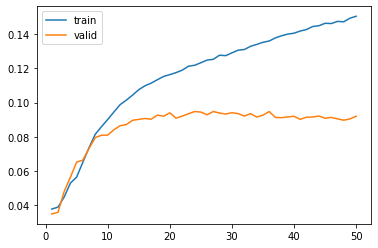

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

### 5 - Predicción de próxima palabra

In [43]:
# Keras pad_sequences
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
# Si la secuencia de entrada supera al input_seq_len (3) se trunca
# Si la secuencia es más corta se agregna ceros al comienzo

In [58]:
# Se utilizará gradio para ensayar el modelo
# Herramienta poderosa para crear interfaces rápidas para ensayar modelos
# https://gradio.app/
import sys
!{sys.executable} -m pip install gradio --quiet

In [45]:
!pip show gradio

Name: gradio
Version: 2.9.1
Summary: Python library for easily interacting with trained machine learning models
Home-page: https://github.com/gradio-app/gradio-UI
Author: Abubakar Abid, Ali Abid, Ali Abdalla, Dawood Khan, Ahsen Khaliq
Author-email: team@gradio.app
License: Apache License 2.0
Location: /Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages
Requires: pycryptodome, ffmpy, analytics-python, paramiko, pandas, python-multipart, orjson, requests, numpy, fastapi, aiohttp, pillow, markdown-it-py, pydub, uvicorn, matplotlib
Required-by: 


In [46]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=3, padding='pre')
    
    # Predicción softmax
    y_hat = model.predict(encoded).argmax(axis=-1)

    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text",
    layout="vertical")

iface.launch(debug=True)

Running on local URL:  http://127.0.0.1:7860/

To create a public link, set `share=True` in `launch()`.


Keyboard interruption in main thread... closing server.


(<fastapi.applications.FastAPI at 0x7faf2fa459d0>,
 'http://127.0.0.1:7860/',
 None)

### 6 - Generación de secuencias nuevas

In [47]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = tokenizer.texts_to_sequences([output_text])[0]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')
		
		# Predicción softmax
        y_hat = model.predict(encoded).argmax(axis=-1)
		# Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for word, index in tokenizer.word_index.items():
            if index == y_hat:
                out_word = word
                break

		# Agrego las palabras a la frase predicha
        output_text += ' ' + out_word
    return output_text

In [48]:
input_text='hey'

generate_seq(model, tok, input_text, max_length=3, n_words=2)

'hey the might'

In [49]:
input_text='we have to'

generate_seq(model, tok, input_text, max_length=3, n_words=1)

'we have to was'

In [61]:
input_text='The Tesseract of your'

generate_seq(model, tok, input_text, max_length=3, n_words=1)

'The Tesseract of your steve'

### 7 - Conclusiones
El modelo entrenado tuvo un muy mail desempeño en el entrenamiento además de overfitting. Cuestiones que podrían mejorarse:
- Agregar más capas o neuronaes
- Incrementar la cantidad de épocas
- Agregar BRNN

Es importante destacar que en este ejemplo estamos entrenando nuestro propios Embeddings, y para ello se requiere mucha data. En los ejemplos que realizaremos de aquí en más utilizaremos más datos, embeddings pre-enternados o modelos pre-entrenados.